# Stats Project: Comparing Coefficient Stability in 3 Cross-Validation Methods

## Intro/Background

In this project, I wanted to explore various cross validation techniques. I compare the accuracy of regressions generated through in-sample cross validation with the accuracy of a "real regression" not bound by the data in one sample. 


## Data Generating for Regression

I start by creating a data generating function for a linear regression problem, with four non-independent random gaussian variables. The variables and resulting regression are plotted below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.datasets import make_regression


/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def generate_date(coeffs,n):
    x1 = np.random.normal(0, 0.1, n)
    x2 = np.random.normal(.5, 0.3, n) + x1
    x3 = np.random.normal(.3, 0.1, n) - x2
    x4 = np.random.normal(0, 0.7, n) + x3
    y = coeffs[0]*x1 + coeffs[1]*x2 + coeffs[2]*x3 + coeffs[3]*x4 + np.random.normal(.2,.1,n)

    df1 = pd.DataFrame({
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'x4': x4,
        'y': y
        })
    return df1

In [3]:
a = 4
b =.3
c = 2
d = 6

coeffs = [a,b,c,d]
n = 10000
df1 = generate_date(coeffs,n)  
df1.head()


,x1,x2,x3,x4,y
0,-0.228374,0.071803,0.381305,0.681755,4.236877
1,-0.021813,0.683664,-0.278980,-0.583122,-3.630171
2,0.096041,0.737341,-0.449332,-0.866508,-5.268265
3,-0.075507,0.721415,-0.364760,-0.904995,-5.841594
4,-0.028638,0.432592,-0.306844,-0.494293,-3.330908


<AxesSubplot:xlabel='y', ylabel='Density'>

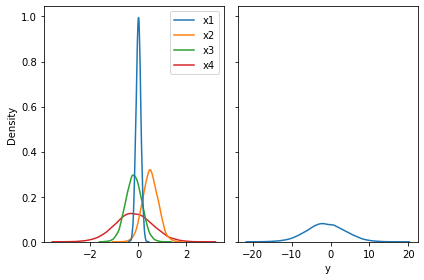

In [4]:
X = df1.drop(['y'], axis=1)
y = df1.y

fig, axes = plt.subplots(1, 2, sharey=True, tight_layout=True)
sns.kdeplot(data=X,ax=axes[0])
sns.kdeplot(data=y,ax=axes[1])


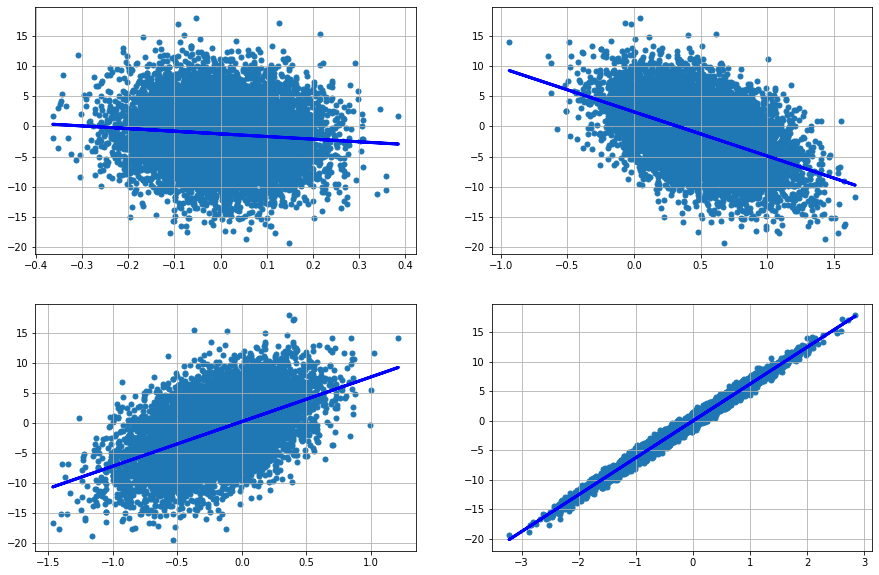

In [5]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    fit = np.polyfit(df1[df1.columns[i-1]],df1['y'],1)
    fit_fn = np.poly1d(fit)
    plt.subplot(2,2,i)
    plt.scatter(df1[df1.columns[i-1]],df1['y'],s=25)
    plt.plot(df1[df1.columns[i-1]],fit_fn(df1[df1.columns[i-1]]),'b-',lw=3)
    plt.grid(True)

Now we can do a linear regression on the data, and compare the generated Y values to the actual y values. We can also see the predicted coefficients. Even though we are using all of the data, the coefficients are not exactly the same as the real values, because the random variables we are using will never cover all possible points.

In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)

print(reg.score(X, y), reg.coef_, reg.intercept_,)

ydf = pd.DataFrame({'Actual': y,'Predicted':reg.predict(X)})
ydf

0.9995785746737593 [3.98751813 0.30823394 2.00060028 6.00160409] 0.1963778063575421


,Actual,Predicted
0,4.236877,4.162327
1,-3.630171,-3.737667
2,-5.268265,-5.292756
3,-5.841594,-6.043500
4,-3.330908,-3.364904
...,...,...
9995,-4.996388,-5.003755
9996,-2.702252,-2.610416
9997,5.502456,5.663198
9998,-3.779440,-3.648526


By running this regression over and over on different sets of generated values, we can draw the "true" distribution of the coefficient values. This will later be used to determine which sampling method will yield the most accurate coefficient distribution.

Text(0.5, 1.0, 'D - True Value 6')

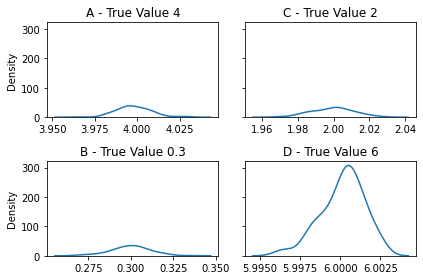

In [7]:
import itertools
a_arr = []
b_arr = []
c_arr = []
d_arr = []

r2_arr = []

for _ in itertools.repeat(None, 100):
    df2 = generate_date(coeffs,n) 
    X = df2.drop(['y'], axis=1)
    y = df2.y
    reg = LinearRegression().fit(X, y)
    a_arr.append(reg.coef_[0])
    b_arr.append(reg.coef_[1])
    c_arr.append(reg.coef_[2])
    d_arr.append(reg.coef_[3])
    
    r2_arr.append(reg.score(X, y))


fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=True)
sns.kdeplot(data=a_arr,ax=axes[0,0]).set_title(f'A - True Value {a}')
sns.kdeplot(data=b_arr,ax=axes[1,0]).set_title(f'B - True Value {b}')
sns.kdeplot(data=c_arr,ax=axes[0,1]).set_title(f'C - True Value {c}')
sns.kdeplot(data=d_arr,ax=axes[1,1]).set_title(f'D - True Value {d}')



In real experiments, we will never have the ability to resample all the data and come up with the true distribution. We have to commit to one sample and use in-sample data. This is where cross-validation comes in. In the next section I will use one set of the data I generated using the function defined in this section, and create test-train splits using various cross-validation techniques. I will compare parameter stability and predictive power using the cross validated sample to the real distribution from this section.


## Cross validation of linear models

Different types of cross-validation that I will explore:
- leave-p-out cross validation
- leave-one-out cross validation
- repeated random sub-sampling (also known as Monte Carlo)
- k-fold cross validation: each data point appears exactly once in the test set, with no repetition

Measures of fit:
- mean squared error
- root mean squared error
- median absolute deviation

In this project I will focus on k-fold, Monte Carlo, and the Bootstrap method (similar to monte-carlo, but with resampling in the train set).
I will compare the distributions of r^2 score and the parameter stability for the coefficients.

I start by two functions: one to generate a series of scores and coefficients for a basic linear regression of any given test-train split, and one that outputs graphs of the coefficient value probability distributions for a given cross-validation method. I also calculate the expected value differences of the "real" distribution and the in-sample distribution. There can be better statistical tests for this, like chi-square or KL divergence, that can be done in the future.


In [8]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate


In [9]:

def get_score_list(cv):
    scores = []
    coeffs = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = LinearRegression().fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        coeffs.append(clf.coef_)
    return scores, coeffs


def show_coeff_divergence(cv,coeffs):
    a_div = statistics.mean(a_arr) - statistics.mean([x[0] for x in coeffs])
    b_div = statistics.mean(b_arr) - statistics.mean([x[1] for x in coeffs])
    c_div = statistics.mean(c_arr) - statistics.mean([x[2] for x in coeffs])
    d_div = statistics.mean(d_arr) - statistics.mean([x[3] for x in coeffs])

    fig, axes = plt.subplots(2, 2, sharey=False, tight_layout=True)
    sns.kdeplot(data=a_arr,ax=axes[0,0]).set_title(f'A - Diff {round(a_div,3)}')
    sns.kdeplot(data=b_arr,ax=axes[1,0]).set_title(f'B - Diff {round(b_div,3)}')
    sns.kdeplot(data=c_arr,ax=axes[0,1]).set_title(f'C - Diff {round(c_div,3)}')
    sns.kdeplot(data=d_arr,ax=axes[1,1]).set_title(f'D - Diff {round(d_div,3)}')

    sns.kdeplot(data=[x[0] for x in coeffs],ax=axes[0,0])
    sns.kdeplot(data=[x[1] for x in coeffs],ax=axes[1,0])
    sns.kdeplot(data=[x[2] for x in coeffs],ax=axes[0,1])
    sns.kdeplot(data=[x[3] for x in coeffs],ax=axes[1,1])
    fig.suptitle(f'Coefficient Mean Divergences for {cv}', fontsize=16)


10-Fold CV Score Probability Distribution


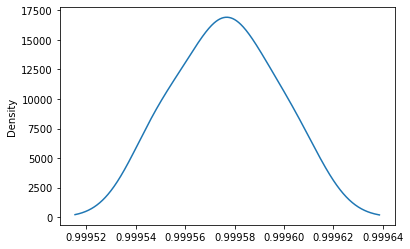

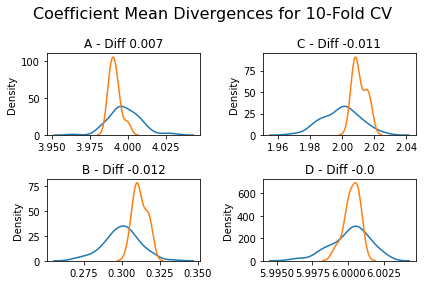

In [10]:
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split

kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf_scores, kf_coeffs = get_score_list(kf)

print("10-Fold CV Score Probability Distribution")
pd.Series(kf_scores).plot.kde()
show_coeff_divergence('10-Fold CV',kf_coeffs)


10-Fold Monte Carlo CV Score Probability Distribution


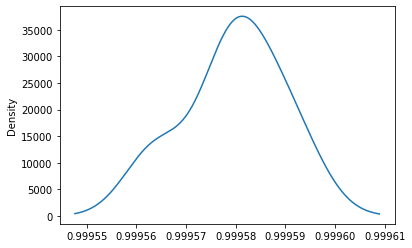

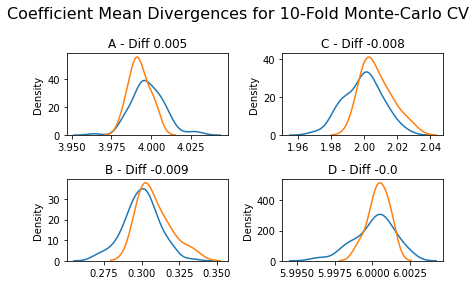

In [11]:
# Montecarlo cross-validation split
mc = ShuffleSplit(n_splits=10, test_size = 0.3 ,random_state=1)
# Returns the number of splitting iterations in the cross-validator
mc.get_n_splits(X)

mc_scores, mc_coeffs = get_score_list(mc)

print("10-Fold Monte Carlo CV Score Probability Distribution")
ax = pd.Series(mc_scores).plot.kde()
show_coeff_divergence('10-Fold Monte-Carlo CV',mc_coeffs)



In this next section I define the bootstrap method. This includes a resampling function to create the training data sets, and a class to generate testing and training sets that makes sure that there is no overlap between testing and training sets.

In [12]:
from sklearn.utils import resample, check_random_state

# Single Bootstrap split
a = resample(X)
test = [item for item in X if item not in a]
print("Train:",a,"  Test:",test)

Train:             x1        x2        x3        x4
9478 -0.008335  0.380154  0.022654  0.340646
9333  0.027058  0.675521 -0.427729 -1.449945
539   0.087105  0.866841 -0.649258 -0.813424
2505  0.013603 -0.036943  0.318083 -0.046592
3583 -0.073780  0.730416 -0.578440 -0.990907
...        ...       ...       ...       ...
3140 -0.036962  0.833040 -0.647069 -1.563435
7475  0.085332  0.881549 -0.596662 -0.444711
2193  0.111447  0.228411  0.080023  1.045714
3932 -0.065913  0.882828 -0.687843 -1.339165
6649  0.055676  0.167508  0.205102 -0.280415

[10000 rows x 4 columns]   Test: []


In [13]:
class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5, random_state=None):
        self.nb = n_bootstraps
        self.rs = random_state
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        rng = check_random_state(self.rs)
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX, random_state=rng)
            test = [item for item in iX if item not in train]
            yield (train,test)
            

10-Fold Bootstrap CV Score Probability Distribution


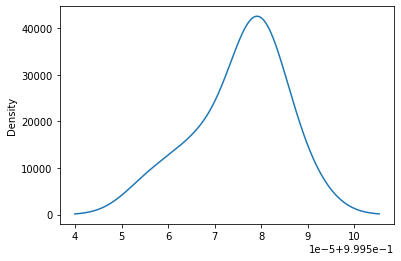

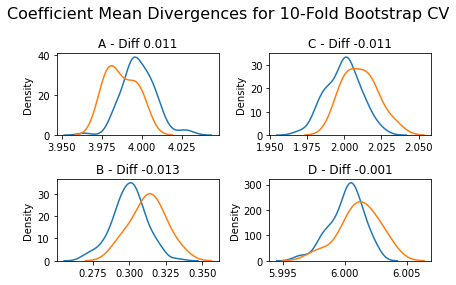

In [14]:
# Bootstrap cross-validator, consistent with similar classes in scikit-learn
boot = Bootstrap(n_bootstraps = 10, random_state=1)
boot_scores, boot_coeffs = get_score_list(boot)

print("10-Fold Bootstrap CV Score Probability Distribution")
pd.Series(boot_scores).plot.kde()
show_coeff_divergence('10-Fold Bootstrap CV',boot_coeffs)
    

Plotting the coefficient distributions allows a quick visual analysis showing that the bootstrap distribution yields the most accurate coefficient distribution when compared to the values generated by the actual data considering the statistical randomness present in the data. This means that when choosing a cross-validation method, bootstrap would be more likely to yield a result that is close to what you would get using real-world data. 

Out of curiosity, I wanted to see how the three cross-validation methods compare at different levels of splits. Below I plotted the score distributions of the three methods at four different split levels. Bootstrap and Monte Carlo trend to converge at higher split levels.

<Figure size 1080x720 with 0 Axes>

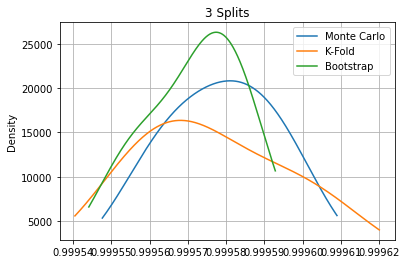

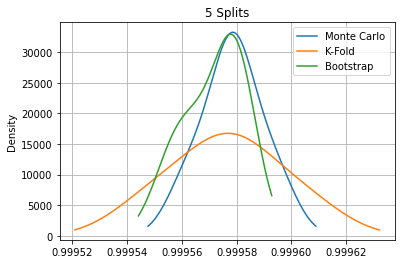

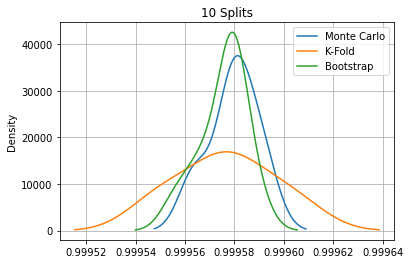

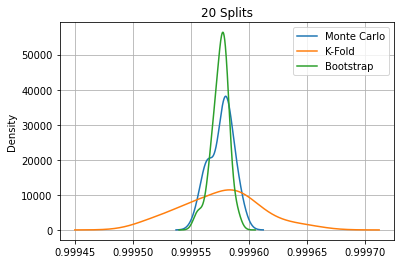

In [15]:
plt.figure(figsize=(15,10))
splits = [3,5,10,20]
for i in splits:
    
    boot = Bootstrap(n_bootstraps = i, random_state=1)
    kf = KFold(n_splits=i, shuffle=True, random_state=1)
    mc = ShuffleSplit(n_splits=i, test_size = 0.3 ,random_state=1)
    
    boot_scores, boot_coeffs = get_score_list(boot)
    kf_scores, kf_coeffs = get_score_list(kf)
    mc_scores, mc_coeffs = get_score_list(mc)
    
    
    df = pd.DataFrame({
        'Monte Carlo': mc_scores,
        'K-Fold': kf_scores,
        'Bootstrap': boot_scores
    })
    ax = df.plot.kde()
    plt.title(f'{i} Splits')
    plt.grid(True)

Sources:
- [Data Generation](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Synthetic_data_generation/Synthetic-Data-Generation.ipynb)
- [8 Types of Cross-Validation](https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d)
- [K Fold, Montecarlo, and Bootstrap](https://nirpyresearch.com/kfold-montecarlo-cross-validation-bootstrap-primer/)
- [Wiki: Stability](https://en.wikipedia.org/wiki/Stability_(probability))